In [ ]:
!pip install -q huggingface_hub git-lfs
!git lfs install

Git LFS initialized.


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
from huggingface_hub import whoami

whoami()


{'type': 'user',
 'id': '683e9b8d5e9fc144193b067f',
 'name': 'Tejaswini628',
 'fullname': 'Sowmya Tejaswini',
 'isPro': False,
 'avatarUrl': '/avatars/74569ad43c78cba9220bdae051f8b764.svg',
 'orgs': [],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'colab-token',
   'role': 'fineGrained',
   'createdAt': '2025-07-18T05:07:44.824Z',
   'fineGrained': {'canReadGatedRepos': False,
    'global': [],
    'scoped': [{'entity': {'_id': '683e9b8d5e9fc144193b067f',
       'type': 'user',
       'name': 'Tejaswini628'},
      'permissions': ['repo.content.read', 'repo.write']}]}}}}

In [ ]:
!rm -rf aptos-fundus-images
!git clone https://huggingface.co/datasets/Tejaswini628/aptos-fundus-images

Cloning into 'aptos-fundus-images'...
remote: Enumerating objects: 5328, done.
remote: Total 5328 (delta 0), reused 0 (delta 0), pack-reused 5328 (from 1)
Receiving objects: 100% (5328/5328), 853.36 KiB | 4.82 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5595/5595), done.
Filtering content: 100% (5590/5590), 9.51 GiB | 38.79 MiB/s, done.


In [ ]:
import pandas as pd

df = pd.read_csv("aptos-fundus-images/data/train.csv")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


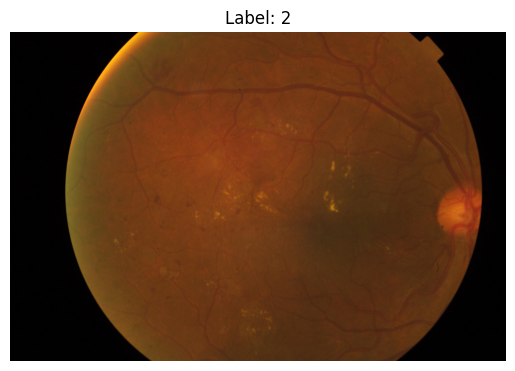

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Get the first row
image_id = df.loc[0, 'id_code']
label = df.loc[0, 'diagnosis']

# Build image path
image_path = f"aptos-fundus-images/data/train_images/{image_id}.png"

# Read image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show it
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
!pip install -q timm
!pip install -q scikit-learn opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load CSV
df = pd.read_csv("aptos-fundus-images/data/train.csv")
df['image_path'] = df['id_code'].apply(lambda x: f"aptos-fundus-images/data/train_images/{x}.png")

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

# Image size
IMG_SIZE = 224

# Transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class APTOSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(self.df.loc[idx, 'image_path']).convert("RGB")
        label = self.df.loc[idx, 'diagnosis']
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = APTOSDataset(train_df, transform=train_transforms)
val_dataset = APTOSDataset(val_df, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import torch.nn as nn
import timm

class APTOS_Ensemble(nn.Module):
    def __init__(self, num_classes=5):
        super(APTOS_Ensemble, self).__init__()
        self.densenet = timm.create_model("densenet121", pretrained=True, num_classes=0, global_pool='avg')
        self.efficientformer = timm.create_model("efficientformer_l1", pretrained=True, num_classes=0, global_pool='avg')
        self.convnext = timm.create_model("convnext_tiny", pretrained=True, num_classes=0, global_pool='avg')

        self.feature_dim = self.densenet.num_features + \
                           self.efficientformer.num_features + \
                           self.convnext.num_features

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        d_out = self.densenet(x)
        e_out = self.efficientformer(x)
        c_out = self.convnext(x)
        combined = torch.cat([d_out, e_out, c_out], dim=1)
        return self.classifier(combined)


In [ ]:
import torch
from torch import optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = APTOS_Ensemble(num_classes=5).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Accuracy function
def compute_accuracy(preds, labels):
    return (preds.argmax(1) == labels).float().mean().item()


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
EPOCHS = 3  # Start with 3 for testing; increase to 10–20 later
best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training mode
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Validation mode
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += compute_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("🔽 Best model saved!")



Epoch 1/3


Validating: 100%|██████████| 23/23 [01:14<00:00,  3.25s/it]


Train Loss: 0.7184, Train Acc: 0.7379
Val Loss:   0.5924, Val Acc:   0.7679
🔽 Best model saved!

Epoch 2/3


Validating: 100%|██████████| 23/23 [01:14<00:00,  3.24s/it]


Train Loss: 0.4900, Train Acc: 0.8116
Val Loss:   0.7085, Val Acc:   0.7093

Epoch 3/3


Validating: 100%|██████████| 23/23 [01:14<00:00,  3.24s/it]


Train Loss: 0.4052, Train Acc: 0.8499
Val Loss:   0.5040, Val Acc:   0.8020
🔽 Best model saved!


In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.train()


APTOS_Ensemble(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32,

In [ ]:
EPOCHS = 10
start_epoch = 3  # Already trained 3 epochs
best_val_acc = 0.8197  # From your earlier run

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(outputs, labels)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += compute_accuracy(outputs, labels)

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("🔽 Best model saved!")



Epoch 4/10


Validating: 100%|██████████| 23/23 [01:14<00:00,  3.23s/it]


Train Loss: 0.2875, Train Acc: 0.8947
Val Loss:   0.6209, Val Acc:   0.8036

Epoch 5/10


Validating: 100%|██████████| 23/23 [01:14<00:00,  3.22s/it]


Train Loss: 0.2386, Train Acc: 0.9113
Val Loss:   0.5341, Val Acc:   0.8251
🔽 Best model saved!

Epoch 6/10


Validating: 100%|██████████| 23/23 [01:13<00:00,  3.21s/it]


Train Loss: 0.1625, Train Acc: 0.9434
Val Loss:   0.6150, Val Acc:   0.8212

Epoch 7/10


Validating: 100%|██████████| 23/23 [01:13<00:00,  3.21s/it]


Train Loss: 0.1207, Train Acc: 0.9589
Val Loss:   0.7347, Val Acc:   0.8059

Epoch 8/10


Validating: 100%|██████████| 23/23 [01:13<00:00,  3.20s/it]


Train Loss: 0.1031, Train Acc: 0.9677
Val Loss:   0.6652, Val Acc:   0.7991

Epoch 9/10


Validating: 100%|██████████| 23/23 [01:13<00:00,  3.19s/it]


Train Loss: 0.0751, Train Acc: 0.9759
Val Loss:   0.7923, Val Acc:   0.8047

Epoch 10/10


Validating: 100%|██████████| 23/23 [01:13<00:00,  3.20s/it]

Train Loss: 0.0695, Train Acc: 0.9773
Val Loss:   0.7229, Val Acc:   0.8209


Classification Report:
                  precision    recall  f1-score   support

           No DR       0.97      0.96      0.96       361
            Mild       0.61      0.55      0.58        74
        Moderate       0.74      0.91      0.81       200
          Severe       0.50      0.21      0.29        39
Proliferative DR       0.62      0.49      0.55        59

        accuracy                           0.83       733
       macro avg       0.69      0.62      0.64       733
    weighted avg       0.82      0.83      0.81       733



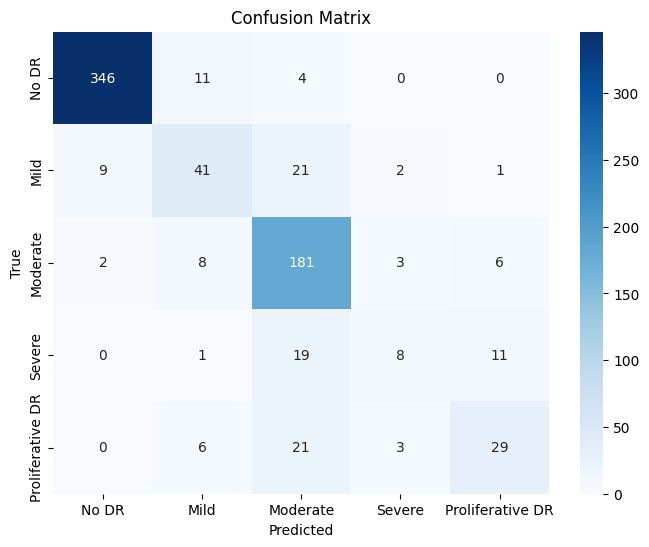

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[
    "No DR", "Mild", "Moderate", "Severe", "Proliferative DR"
]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"],
            yticklabels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
from torchvision import transforms
from PIL import Image
import pandas as pd

# Load best model again (just in case)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# Prepare transforms (same as training/val)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Read sample submission for ID order
submission_df = pd.read_csv("aptos-fundus-images/data/sample_submission.csv")
predictions = []

for img_id in submission_df['id_code']:
    img_path = f"aptos-fundus-images/data/test_images/{img_id}.png"
    image = Image.open(img_path).convert("RGB")
    image = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1).cpu().item()
    predictions.append(pred)

# Create and save submission file
submission_df['diagnosis'] = predictions
submission_df.to_csv("submission.csv", index=False)
print("✅ Predictions complete. Saved to submission.csv")


✅ Predictions complete. Saved to submission.csv


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.preprocessing import label_binarize
import seaborn as sns
import pandas as pd

# Classes
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
n_classes = len(class_names)

# Convert to numpy
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Compute probabilities for each class
model.eval()
y_scores = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        y_scores.extend(outputs.cpu().numpy())
y_scores = np.array(y_scores)

# Binarize labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])


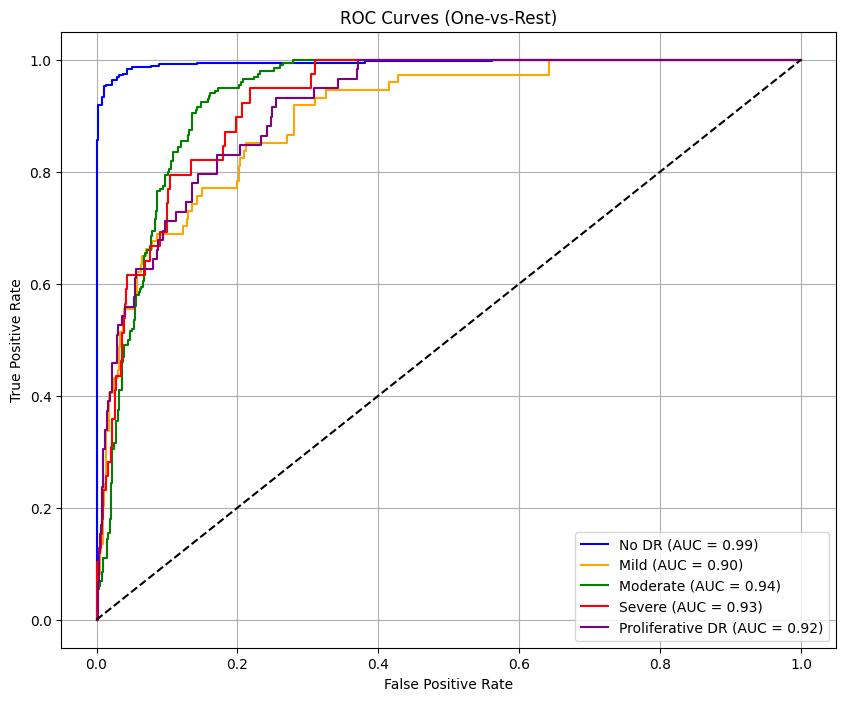

Micro AUC: 0.9666
Macro AUC: 0.9353


In [ ]:
# 1. ROC Curves (One-vs-Rest) and AUC

fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro/Macro AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Micro AUC: {roc_auc['micro']:.4f}")
print(f"Macro AUC: {roc_auc['macro']:.4f}")



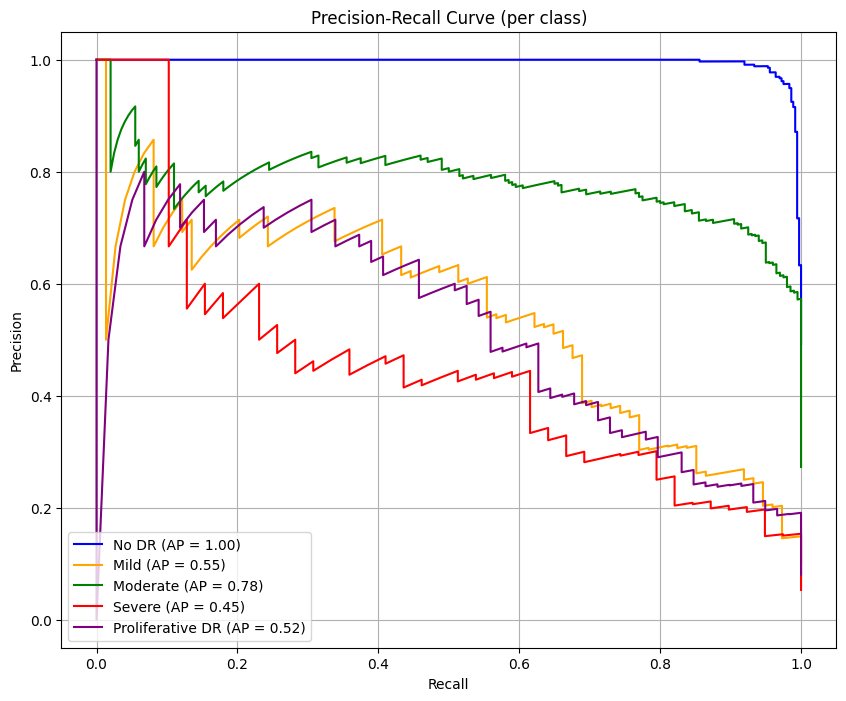

In [ ]:
#  2. Precision-Recall Curves + Average Precision (AP)
precision, recall, average_precision = {}, {}, {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (per class)")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [ ]:
# 3. Cohen’s Kappa & MCC
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Cohen's Kappa Score: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Cohen's Kappa Score: 0.7326
Matthews Correlation Coefficient: 0.7357


In [ ]:
#  4. Save Classification Report to CSV
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("classification_report.csv")
print("📄 Saved classification report to classification_report.csv")


📄 Saved classification report to classification_report.csv


In [ ]:
# 5. Optional: Save Evaluation Summary Table for Paper
summary = []
for i in range(n_classes):
    summary.append({
        "Class": class_names[i],
        "Precision": report_dict[class_names[i]]['precision'],
        "Recall": report_dict[class_names[i]]['recall'],
        "F1-Score": report_dict[class_names[i]]['f1-score'],
        "AUC": roc_auc[i],
        "AP": average_precision[i]
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv("evaluation_summary.csv", index=False)
print("📊 Saved evaluation summary to evaluation_summary.csv")
display(summary_df)


📊 Saved evaluation summary to evaluation_summary.csv


,Class,Precision,Recall,F1-Score,AUC,AP
0,No DR,0.969188,0.958449,0.963788,0.994966,0.995764
1,Mild,0.611940,0.554054,0.581560,0.898802,0.549008
2,Moderate,0.735772,0.905000,0.811659,0.936060,0.780547
3,Severe,0.500000,0.205128,0.290909,0.926993,0.454864
4,Proliferative DR,0.617021,0.491525,0.547170,0.916436,0.524575


In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=178e5c02f58e19f9eb103a586a0138fc74cfbe7dd477eeeff8f89aeb96e070a7
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


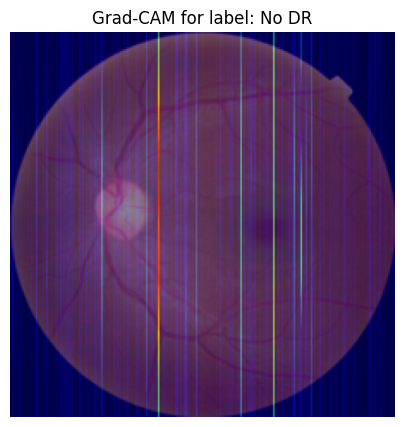

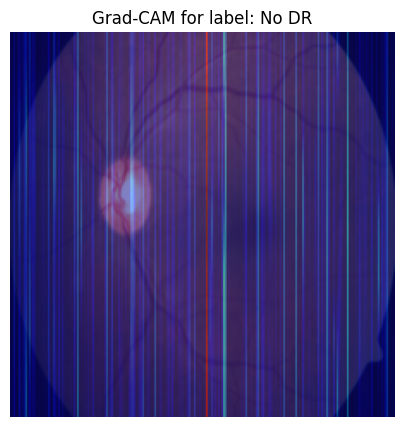

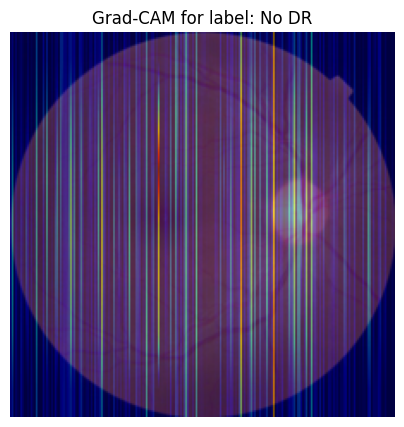

In [ ]:
# 6. Grad-CAM (Model Explainability)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is on CUDA manually
model = model.cuda() if torch.cuda.is_available() else model.cpu()

# Target layer from ConvNeXt (last block norm layer)
target_layer = model.convnext.stages[-1].blocks[-1].norm

# ✅ No 'use_cuda' or 'device' param now — just pass model and target_layer
cam = GradCAM(model=model, target_layers=[target_layer])

# Visualize Grad-CAM for selected samples
for idx in [0, 5, 10]:
    image_tensor, label = val_dataset[idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)

    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])
    grayscale_cam = grayscale_cam[0, :]

    # Unnormalize
    rgb_image = image_tensor.permute(1, 2, 0).numpy()
    rgb_image = (rgb_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    rgb_image = np.clip(rgb_image, 0, 1)

    # Overlay CAM
    visualization = show_cam_on_image(rgb_image.astype(np.float32), grayscale_cam, use_rgb=True)

    plt.figure(figsize=(5, 5))
    plt.title(f"Grad-CAM for label: {class_names[label]}")
    plt.imshow(visualization)
    plt.axis("off")
    plt.show()


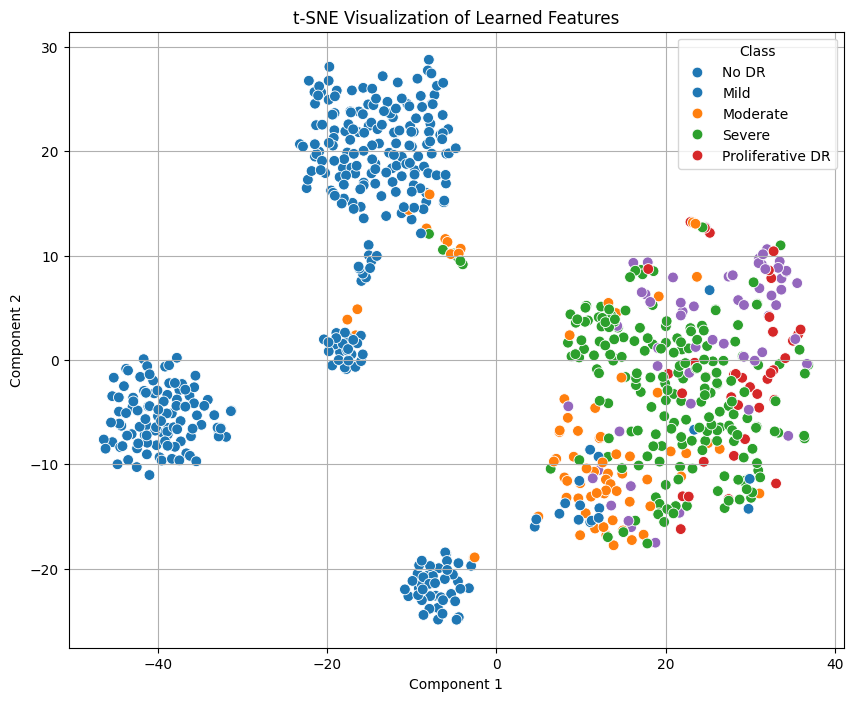

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

# Collect deep features
features, labels = [], []

model.eval()
with torch.no_grad():
    for images, lbls in val_loader:
        images = images.to(device)
        d_out = model.densenet(images)
        e_out = model.efficientformer(images)
        c_out = model.convnext(images)
        combined = torch.cat([d_out, e_out, c_out], dim=1)
        features.append(combined.cpu().numpy())
        labels.extend(lbls.numpy())

features = np.concatenate(features)

# Dimensionality reduction (t-SNE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10', s=60)
plt.title("t-SNE Visualization of Learned Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", labels=class_names)
plt.grid(True)
plt.show()


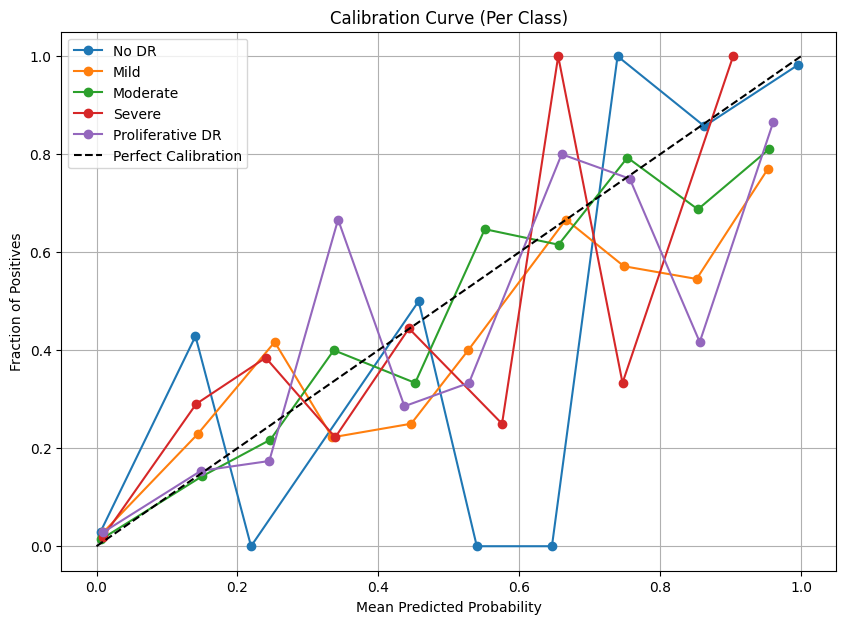

In [ ]:
# 8. Calibration Curves (Reliability Diagrams)
import torch.nn.functional as F
from sklearn.calibration import calibration_curve

# Apply softmax to get probabilities from raw logits
y_probs = F.softmax(torch.tensor(y_scores), dim=1).numpy()  # shape: (n_samples, n_classes)

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], y_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=class_names[i])

plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Per Class)")
plt.legend()
plt.grid(True)
plt.show()



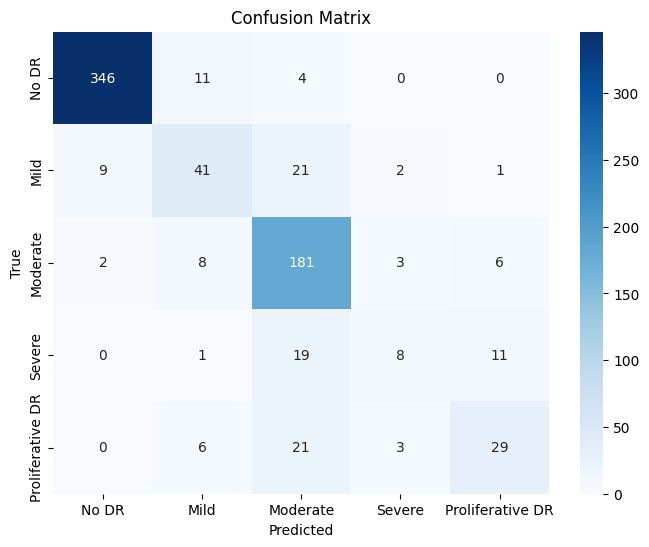

In [ ]:
#  9. Confusion Matrix (Heatmap)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#  10. Top-k Accuracy (e.g., Top-2, Top-3)
import torch

topk = [1, 2, 3]
correct_topk = {k: 0 for k in topk}

y_true_tensor = torch.tensor(y_true)
y_probs_tensor = torch.tensor(y_probs)

for k in topk:
    topk_preds = y_probs_tensor.topk(k, dim=1).indices
    correct = sum([y_true_tensor[i] in topk_preds[i] for i in range(len(y_true))])
    correct_topk[k] = correct / len(y_true)

for k, acc in correct_topk.items():
    print(f"Top-{k} Accuracy: {acc:.4f}")


Top-1 Accuracy: 0.8254
Top-2 Accuracy: 0.9427
Top-3 Accuracy: 0.9877


In [ ]:
!pip install netcal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing

In [ ]:
# 11. Expected Calibration Error (ECE)
from netcal.metrics import ECE

ece = ECE(10)  # 10 bins
ece_score = ece.measure(y_probs, y_true)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0716


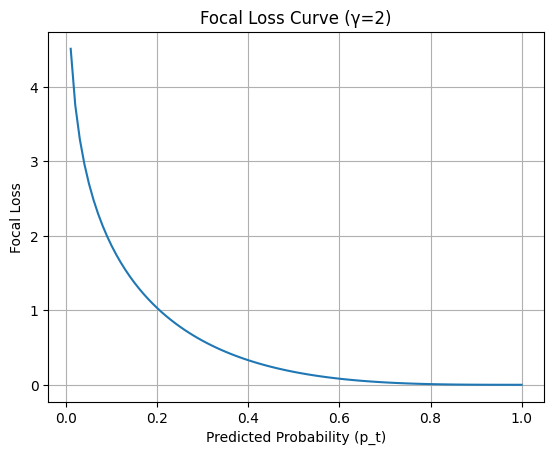

In [ ]:
# 12. Focal Loss Curve (If You Use Focal Loss)
import numpy as np
import matplotlib.pyplot as plt

def focal_loss(p_t, gamma=2.0):
    return -((1 - p_t) ** gamma) * np.log(p_t)

p_t = np.linspace(0.01, 1.0, 100)
loss = focal_loss(p_t)

plt.plot(p_t, loss)
plt.title('Focal Loss Curve (γ=2)')
plt.xlabel('Predicted Probability (p_t)')
plt.ylabel('Focal Loss')
plt.grid()
plt.show()
